# Imports

In [1]:
import pandas as pd
import json
from plotnine import *
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Model, Sequential
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
import keras

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
with open('/home/msnow/git/bgg/data/crawler/game_comments.json', 'r') as fp:
    game_comments = json.load(fp)

In [3]:
comment_list = []
score_list = []
for ky in game_comments.keys():
    comment_list += game_comments[ky]
    score_list += [float(ky)]*len(game_comments[ky])
df_comments = pd.DataFrame({'scores': score_list, 'comments': comment_list})
df_comments.head()

,scores,comments
0,10.0,"Great, epic 18xx game; after one play, it feel..."
1,10.0,Print and play de Robert Lecuyer
2,10.0,This is one of my favorite 18xx games . It ha...
3,10.0,My current favorite 18xx title.
4,10.0,"I don't love this game, but I have to say, it'..."


In [5]:
df_sample = df_comments.sample(n=2*10**5, random_state=43)
df_comments.shape, df_sample.shape

((1699992, 2), (200000, 2))

# EDA

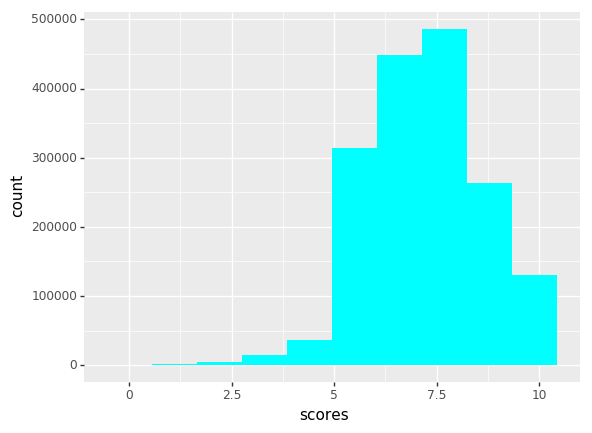

<ggplot: (-9223363267596462297)>

In [52]:
ggplot(df_comments, aes(x='scores')) + geom_histogram(bins=10, fill='cyan')

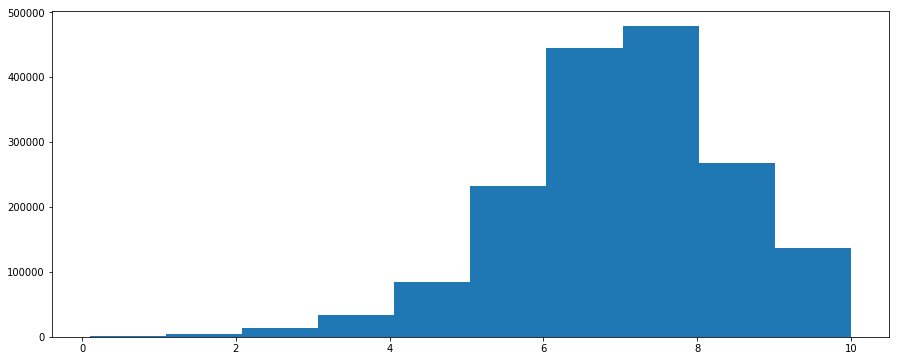

In [53]:
plt.figure(figsize=(15,6))
plt.hist(df_comments.scores, bins=10);

# Process the text

In [6]:
df_sample['tokens'] = df_sample.comments.map(lambda x: simple_preprocess(x))

# Create the text embedding

In [7]:
class EmbedText:

    def __init__(self):
        self.train_corpus = None

    def d2v_setup(self, df: pd.DataFrame, text_col: str, emb_size: int = 100):
        self.train_corpus = []
        for idx, row in df.iterrows():
            self.train_corpus.append(TaggedDocument(row[text_col], [idx]))
        self.model_d2v = Doc2Vec(vector_size=emb_size, dm=0, min_count=2, workers=6, epochs=1, min_alpha=0.025, alpha=0.025)
        self.model_d2v.build_vocab(self.train_corpus)

    def d2v_fit(self, epochs: int = 10, decay_rate: float = 0.002):
        for _ in tqdm(range(epochs)):
            self.model_d2v.train(self.train_corpus, total_examples=self.model_d2v.corpus_count, epochs=epochs)
            self.model_d2v.alpha -= decay_rate
            self.model_d2v.min_alpha = self.model_d2v.alpha
        return self.model_d2v

    def d2v_embed_save(self, loc: str):
        self.model_d2v.save(loc)

    def d2v_vectors(self, df: pd.DataFrame, text_col: str):
        return df.loc[:, text_col].map(lambda x: self.model_d2v.infer_vector(x).tolist())

In [8]:
embd_10 = EmbedText()
embd_10.d2v_setup(df_sample.sample(n=10**4, random_state=43), text_col='tokens', emb_size=10)
embd_10.d2v_fit(epochs=10)

100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


In [9]:
embd_50 = EmbedText()
embd_50.d2v_setup(df_sample.sample(n=10**4, random_state=43), text_col='tokens', emb_size=50)
embd_50.d2v_fit(epochs=10)

100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


In [8]:
mdl_path = '/home/msnow/git/bgg/data/embed/game_comments_sampled.d2v'
embd.d2v_embed_save(mdl_path)

In [10]:
df_sample['vectors_10'] = embd_10.d2v_vectors(df_sample, text_col='tokens')
df_sample['vectors_50'] = embd_50.d2v_vectors(df_sample, text_col='tokens')

# Prepare the data for training

In [11]:
def split_data(idx, train_ratio: float = 0.6, val_ratio: float = None, holdout: bool = False, rnd_seed: int = 24):
    idx_train, idx_test = train_test_split(idx, test_size= 1-train_ratio, random_state=rnd_seed)
    if holdout and val_ratio is not None:
        val_ratio_rel = val_ratio / (1 - train_ratio)
        idx_test, idx_val = train_test_split(idx_test, test_size=val_ratio_rel, random_state=rnd_seed)
    else:
        idx_val = None
    return idx_train, idx_test, idx_val

In [12]:
idx_train, idx_test, idx_val = split_data(df_sample.index, holdout=True, val_ratio=0.1)
idx_train.shape, idx_test.shape, idx_val.shape

((120000,), (60000,), (20000,))

In [13]:
sclr = MinMaxScaler().fit(np.reshape(df_sample.scores.values,(-1,1)))
y_train = np.squeeze(sclr.transform(np.reshape(df_sample.loc[idx_train, 'scores'].values,(-1,1))))
y_test = np.squeeze(sclr.transform(np.reshape(df_sample.loc[idx_test, 'scores'].values,(-1,1))))
y_val = np.squeeze(sclr.transform(np.reshape(df_sample.loc[idx_val, 'scores'].values,(-1,1))))
x_val_10 = np.array(df_sample.loc[idx_val,'vectors_10'].tolist())
x_test_10 = np.array(df_sample.loc[idx_test,'vectors_10'].tolist())
x_train_10 = np.array(df_sample.loc[idx_train,'vectors_10'].tolist())
x_val_50 = np.array(df_sample.loc[idx_val,'vectors_50'].tolist())
x_test_50 = np.array(df_sample.loc[idx_test,'vectors_50'].tolist())
x_train_50 = np.array(df_sample.loc[idx_train,'vectors_50'].tolist())

# Sequential Model

In [15]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=x_train_10.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='mse', optimizer=SGD(lr=0.2), metrics=['mean_squared_error'])
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model.fit(x_train_10, y_train, epochs=3, batch_size = 128, validation_data=[x_test_10, y_test])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 120000 samples, validate on 60000 samples
Epoch 1/3
120000/120000 [==============================] - 1s 7us/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 2/3
120000/120000 [==============================] - 1s 5us/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 3/3
120000/120000 [==============================] - 1s 5us/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0188 - val_mean_squared_error: 0.0188


In [16]:
model.evaluate(x_val_10, y_val)

20000/20000 [==============================] - 0s 5us/step


[0.018490521759539844, 0.018490521759539844]

In [17]:
x_pred = model.predict(x_val_10[:10])
np.concatenate((sclr.inverse_transform(x_pred), sclr.inverse_transform(np.reshape(y_val[:10],(-1,1)))),1)

array([[ 7.26938534,  6.5       ],
       [ 8.14490128,  8.5       ],
       [ 7.79084349,  9.        ],
       [ 7.49051714,  8.5       ],
       [ 7.05470085,  8.        ],
       [ 7.25369024,  7.        ],
       [ 7.37356138,  7.        ],
       [ 7.57329988, 10.        ],
       [ 7.53865051,  7.        ],
       [ 7.06797695,  7.        ]])

In [23]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=x_train_50.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='mse', optimizer=SGD(lr=0.2), metrics=['mean_squared_error'])
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model.fit(x_train_50, y_train, epochs=3, batch_size = 32, validation_data=[x_test_50, y_test])

Train on 120000 samples, validate on 60000 samples
Epoch 1/3
120000/120000 [==============================] - 2s 20us/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 2/3
120000/120000 [==============================] - 2s 19us/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 3/3
120000/120000 [==============================] - 2s 19us/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0179 - val_mean_squared_error: 0.0179


In [24]:
model.evaluate(x_val_50, y_val)

20000/20000 [==============================] - 0s 10us/step


[0.0175989424854517, 0.0175989424854517]

In [25]:
x_pred = model.predict(x_val_50[:10])
np.concatenate((sclr.inverse_transform(x_pred), sclr.inverse_transform(np.reshape(y_val[:10],(-1,1)))),1)

array([[ 7.48511982,  6.5       ],
       [ 7.96741962,  8.5       ],
       [ 8.38750553,  9.        ],
       [ 7.81949568,  8.5       ],
       [ 7.62762451,  8.        ],
       [ 7.12237453,  7.        ],
       [ 7.72806644,  7.        ],
       [ 8.07627773, 10.        ],
       [ 7.25026655,  7.        ],
       [ 7.15022659,  7.        ]])

In [74]:
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(32, activation='relu', input_dim=100))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
model.fit(train_x, train_y,
          epochs=6,
          batch_size=64)
score = model.evaluate(test_x, test_y, batch_size=128)

Epoch 1/6
60000/60000 [==============================] - 1s 14us/step - loss: 7.6817 - acc: 0.0000e+00
Epoch 2/6
60000/60000 [==============================] - 1s 9us/step - loss: 7.3362 - acc: 0.0000e+00
Epoch 3/6
60000/60000 [==============================] - 1s 9us/step - loss: 7.3260 - acc: 0.0000e+00
Epoch 4/6
60000/60000 [==============================] - 1s 9us/step - loss: 7.3235 - acc: 0.0000e+00
Epoch 5/6
60000/60000 [==============================] - 1s 9us/step - loss: 7.3228 - acc: 0.0000e+00
Epoch 6/6
40000/40000 [==============================] - 0s 6us/step


In [75]:
train_y

array([-0.29018017, -0.04953381, -1.54176467, ..., -0.02679499,
        0.0443393 ,  9.2227916 ])

In [76]:
test_y

array([-2.68902122,  1.45500776,  1.21511293, ..., -0.17123162,
       -0.12158073, -7.53054651])

In [77]:
model.predict(test_x)

array([[0.        ],
       [0.9973669 ],
       [0.988399  ],
       ...,
       [0.01201296],
       [0.01989004],
       [0.        ]], dtype=float32)

In [66]:
score

[42.80363713378906, 0.001225]

# Model the data

In [47]:
def reg_model_build(embed_size: int = 100):
    word_input = Input(shape=embed_size)
    x = Dense(128, activation='relu')(word_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    preds = Dense(1, activation='linear')(x)
    model = Model(word_input, preds)
    return model

In [48]:
model = reg_model_build(embed_size = 100)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
history = model.fit(train_x,
                    train_y,
                    validation_data=(test_x, test_y),
                    epochs=6,
                    batch_size=64)

TypeError: 'int' object is not iterable

In [ ]:
class Models:

    def __init__(self, x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray,
                 x_val: np.ndarray = None, y_val: np.ndarray = None, embed_size: int = 100):
        self.embed_size = embed_size
        self.model = None
        self.x_train = x_train
        self.x_test = x_test
        self.x_val = x_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val
        self.history = None
        self.herstory = Summary_metrics()

    def cnn_build(self, out_class: int = 2):
        word_input = Input(shape=(self.embed_size, 1))
        x = Conv1D(256, 3, activation='relu')(word_input)
        x = MaxPooling1D(3)(x)
        x = Conv1D(256, 3, activation='relu')(x)
        x = MaxPooling1D(3)(x)
        x = Conv1D(128, 3, activation='relu')(x)
        x = MaxPooling1D(2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        preds = Dense(out_class, activation='softmax')(x)
        self.model = Model(word_input, preds)

    @staticmethod
    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


    @staticmethod
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall = 5
        return recall

    def f1(self, y_true, y_pred):
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def cnn_compile(self):
        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           # metrics=['acc', self.recall, self.precision, self.f1])
                           metrics=['acc'])

    def cnn_train(self, epochs: int = 10, batch_size: int = 128, class_weight: dict = None):
        self.history = self.model.fit(self.x_train,
                                      self.y_train,
                                      validation_data=(self.x_test, self.y_test),
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      callbacks=[self.herstory],
                                      class_weight = class_weight)

    def model_save(self, loc: str):
        self.model.save(loc)